In [8]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
sys.path.append('/usr/users/fsimone/tejaas')
from iotools import readgtf
import numpy as np
import os
import re
import collections
import time 

SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp', 'dbSNP', 'maf']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()

def tejaas(filepath, dbsnp_dict):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            chrom = rsid.split("_")[0][3:]
            pos   = int(arr[2])
            p     = float(arr[7])
            logp  = np.log10(p) if p!=0 else np.log10(10e-30)
            maf   = float(arr[3])
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, dbSNP=dbsnp_dict[rsid], maf=maf))
    return res    

def tejaas_old(filepath, dbsnp_dict):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            chrom = rsid.split("_")[0][3:]
            pos   = int(arr[1])
            p     = float(arr[5])
            logp  = np.log10(p) if p!=0 else np.log10(10e-30)
            maf   = float(arr[7])
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, dbSNP=dbsnp_dict[rsid], maf=maf))
    return res   

def tejaas_saikat(filepath, dbsnp_dict):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            chrom = int(arr[1])
            pos   = int(arr[2])
            p     = float(arr[3])
            logp  = np.log10(p) if p!=0 else np.log10(10e-30)
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, dbSNP=dbsnp_dict[rsid]))
    return res

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get dbSNP 151 rsids

In [2]:
import gzip 

dbsnp_dict = dict()
with gzip.open("/cbscratch/franco/datasets/gtex_v8/genotypes/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.lookup_table.txt.gz") as instream:
    next(instream)
    for line in instream:
        arr = line.decode().rstrip().split()
        #if len(arr[3]) == 1 and len(arr[4]) == 1:
        dbsnp_dict[arr[2]] = arr[6]

# Load Trans-eQTLS

In [9]:
from utils import utils
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/analysis/plots/tissues.txt"
tissuenames, descriptions = utils.read_tissues(tissue_file)


# basepath = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8"
# trans_dict = dict()
# for tissue in tissuenames:
#     tejaas_file = os.path.join(basepath+"_tejaas_permnull_sb0.1_knn", tissue, "trans_eqtls.txt")
#     if not os.path.exists(tejaas_file):
#         print("{:s} has no trans-eqtl results".format(tissue))
#         continue
#     print("Loading ", tissue)
#     transeqtls = tejaas_saikat(tejaas_file, dbsnp_dict)
#     if len(transeqtls) > 200:
#         trans_dict[tissue] = transeqtls


# basepath = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_lncRNA_freeze/"
# trans_dict = dict()
# for tissue in tissuenames:
#     tejaas_file = os.path.join(basepath, "summary_5e-08", tissue, "tejaas", "trans_eqtls.txt")
#     if not os.path.exists(tejaas_file):
#         print("{:s} has no trans-eqtl results".format(tissue))
#         continue
#     print("Loading ", tissue)
#     transeqtls = tejaas(tejaas_file, dbsnp_dict)
#     if len(transeqtls) > 0:
#         trans_dict[tissue] = transeqtls
#     else:
#         print("{:s} has 0 trans-eqtls".format(tissue))
        
basepath = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_dysb/"
trans_dict = dict()
for tissue in tissuenames:
    tejaas_file = os.path.join(basepath, "summary_5e-08_k0.5", tissue, "tejaas", "trans_eqtls.txt")
    if not os.path.exists(tejaas_file):
        print("{:s} has no trans-eqtl results".format(tissue))
        continue
    print("Loading ", tissue)
    transeqtls = tejaas_old(tejaas_file, dbsnp_dict)
    if len(transeqtls) > 0:
        trans_dict[tissue] = transeqtls
    else:
        print("{:s} has 0 trans-eqtls".format(tissue))

Loading  aa
Loading  ms
Loading  wb


# Load GWAS Catalog

In [10]:
gwas_cat = "/cbscratch/franco/datasets/GWAScatalog/gwas_catalog_v1.0-associations_e96_r2019-08-24.tsv"
gwas_pos_dict = collections.defaultdict(dict)
skip = 0
loaded = 0
weird_snps = list()
gwas_rsid_dict = collections.defaultdict(lambda: False)
gwas_rsid_trait = dict()
gwas_rsid_list = list()
with open(gwas_cat) as instream:
    header = instream.readline().rstrip().split("\t")
    # header[17] SNP_GENE_IDS
    print( header[7], header[11], header[12], header[21], header[22], header[23], header[27])
    for line in instream:
        arr = line.rstrip().split("\t")
        # df_gwas.iloc[:,[12,23,27]]
        trait = arr[7]
        chrm  = arr[11]
        bp_pos= arr[12]
        snps  = arr[21]
        snp_id_current = arr[23]
        pval  = arr[27]
        if re.search(";", snps):
            bp_pos_arr = bp_pos.split(";")
            snps_arr   = snps.split(";")
            chrm_arr   = chrm.split(";")
            # print(bp_pos_arr, snps_arr)
            if len(bp_pos_arr) != len(snps_arr) and len(snps_arr) != len(chrm_arr):
                if len(bp_pos_arr) == len(chrm_arr):
                    new_snps_arr = [s.strip() for s in snps_arr if s.strip().startswith('rs')]
                    if len(new_snps_arr) == len(bp_pos_arr):
                        print("good!", new_snps_arr, bp_pos_arr, chrm_arr)
                        for i in range(len(new_snps_arr)):
                            gwas_rsid_list.append(new_snps_arr[i])
                            gwas_pos_dict[chrm_arr[i]][bp_pos_arr[i]] = new_snps_arr[i]
                            loaded += 1
                    else:
                        print("wtf!", snps_arr, new_snps_arr, bp_pos_arr, chrm_arr)
                        skip += 1
                else:
                    skip += 1
                    print(bp_pos_arr, snps_arr, chrm_arr)
                    weird_snps.append((bp_pos_arr, snps_arr, chrm_arr))
                    continue
            else:
                for s in snps_arr:
                    if s.strip().startswith('rs'):
                        gwas_rsid_dict[s.strip()] = True
                        gwas_rsid_trait[s.strip()] = trait
                        gwas_rsid_list.append(s.strip())
                        loaded += 1
                    else:
                        print("WTF, ",s)
            if len(bp_pos_arr) == len(snps_arr) and len(snps_arr) == len(chrm_arr):
                for i in range(len(snps_arr)):
                    gwas_pos_dict[chrm_arr[i]][bp_pos_arr[i]] = snps_arr[i]
                    loaded += 1
        else:
            if snps.startswith('rs'):
                gwas_rsid_dict[snps] = True
                gwas_rsid_trait[snps] = trait
                gwas_rsid_list.append(snps)
                gwas_pos_dict[chrm][bp_pos] = snps
                loaded += 1
                #print( bp_pos, snps, "|", snp_id_current)
            else:
                print("HA!", snps, chrm, bp_pos)
print("Skipped {:d} GWAS snps".format(skip))
print("{:d} GWAS SNPs loaded".format(loaded))

DISEASE/TRAIT CHR_ID CHR_POS SNPS MERGED SNP_ID_CURRENT P-VALUE
HA! GSTM1 Del  
HA! HLA-A*3101  
HA! 6:32588205  
HA! APOE-E4  
HA! APOE-E3  
HA! H1H2  
HA! GA009635  
HA! SNP2-179127489  
HA! SNP3-186373264  
HA! ch2:211694960  
HA! APOE  
HA! HLA-A*02:01  
HA! Position 173336636  
HA! HLA-A*01:01  
HA! HLA-A*03:01  
HA! HLA-B*08:01  
HA! HLA-B*15:01  
HA! HLA-B*57:01  
HA! HLA-C*07:01  
HA! HLA-C*03:04  
HA! HLA-C*03:03  
HA! SNP_A-2171106  
HA! SNP_A-1841655  
HA! HLA-B*0702  
HA! DRB1*1301-DQA1*0103-DQB1*0603  
HA! DRB1*1501-DQB1*0602  
HA! DRB*15:01  
HA! DRB*13:03  
HA! DRB*03:01  
HA! A*02:01  
HA! DRB*08:01  
HA! 16-78042454  
HA! chr17:8631468  
HA! chr8:78718310  
HA! chr11:1421138  
HA! chr9:136149095  
HA! chr17:61538148  
HA! kgp15327256  
HA! kgp8851185  
HA! kgp7569258  
HA! kgp5819435  
HA! kgp10557168  
HA! kgp12317355  
HA! kgp8087771  
HA! kgp16051801  
HA! kgp14646698  
HA! kgp12078483  
HA! kgp22358183  
HA! kgp12303217  
HA! kgp4108347  
HA! kgp8037522  
HA! kgp76

HA! HLA-DQB1*602  
HA! HLA-DQA1*0301  
HA! HLA-B*15  
HA! HAL-DRB1*13  
HA! imm_6_167338101  
HA! imm_6_167338101  
HA! chr1:100993403  
HA! chr1:15758679  
HA! chr1:15759699  
HA! chr1:16032902  
HA! chr10:120837903  
HA! chr16:75232655  
HA! chr16:75268060  
HA! chr3:126728393  
HA! chr7:142460744  
HA! chr7:142478368  
HA! chr7:142478687  
HA! chr7:142481656  
HA! chr7:142481922  
HA! chr9:14197788  
HA! chr9:15057589  
HA! chrX:106171175  
HA! chrX:106392776  
HA! chrX:106507551  
HA! chrX:106517502  
HA! chrX:106527804  
HA! chr8:121446432  
HA! kgp5929161  
HA! HLA-A*02:01  
HA! HLA-B*44:02  
HA! HLA-C*02:02  
HA! HLA-C*05:01  
HA! A*03:01  
HA! C*03:04  
HA! DQA1*01:02  
HA! DQA1*03:01  
HA! DQB1*06:02  
HA! DRB1*04:04  
HA! DRB1*15:01  
HA! chr9:136149095  
HA! X:146986184:A_AAA  
HA! A*01:01  
HA! B*18:01  
HA! B*35:02  
HA! C*04:01  
HA! DRB1*11:04  
HA! chr12:76206639  
HA! DQB1*06:02  
HA! A*02:05  
HA! DRB1*04:01  
HA! DQA1*03:01  
HA! DQA1*03:03  
HA! DRB1*15:01  
HA! DQA

HA! chr19:46800136  
HA! chr19:46800433  
HA! chr19:46800433  
HA! chr19:46802122  
HA! chr1:109824250  
HA! chr2:21239667  
HA! chr19:19366632  
HA! chr19:19494483  
HA! chr19:19727152  
HA! chr8:20853599  
HA! chr3:124494121  
HA! chr4:167833247  
HA! chr13:97924003  
HA! chr18:47710261  
HA! chr2:21203877  
HA! chr19:43545210  
HA! chr19:45411941  
HA! chr2:178441119  
HA! chr3:148625860  
HA! chr3:148823617  
HA! chr4:74265673  
HA! chr2:21150787  
HA! chr17:4692640  
HA! chr17:4829695  
HA! chr19:11398422  
HA! chr4:74265673  
HA! chr1:230308906  
HA! chr2:21193946  
HA! chr6:34627437  
HA! chr6:34830162  
HA! chr8:19816238  
HA! chr8:19934339  
HA! chr8:20853599  
HA! chr9:15304782  
HA! chr9:107589744  
HA! chr11:47277094  
HA! chr11:47475189  
HA! chr11:47646987  
HA! chr11:47877493  
HA! chr11:116623213  
HA! chr15:57680883  
HA! chr15:57934701  
HA! chr15:58441366  
HA! chr15:58723479  
HA! chr15:58855748  
HA! chr15:59302462  
HA! chr15:59427807  
HA! chr16:56988044  
HA! ch

HA! chr1:12175658  
HA! chr1:12175658  
HA! chr1:65491914  
HA! chr10:94450233  
HA! chr11:309127  
HA! chr16:68294800  
HA! chr19:3179884  
HA! chr19:16430149  
HA! chr9:6282511  
HA! chr1:12175658  
HA! chr2:8441735  
HA! chr3:169518455  
HA! chr3:194403578  
HA! chr9:6282511  
HA! chr6:74457830  
HA! chr4:22306890  
HA! chr11:44507543  
HA! chr11:68859870  
HA! chr7:127643968  
HA! chr10:18645086  
HA! chr3:74772076  
HA! chr7:110586940  
HA! chr7:30288256  
HA! chr15:49195281  
HA! chr16:24205678  
HA! chr4:55430998  
HA! chr15:28714945  
HA! chr10:7989475  
HA! chr3:169730124  
HA! chr6:78769132  
HA! chr16:81643746  
HA! chr16:13310075  
HA! chr11:121919647  
HA! chr2:114875550  
HA! chr13:61466895  
HA! chr7:3028590  
HA! chr6:151134333  
HA! chr3:81678329  
HA! chr4:7940685  
HA! chr5:174741726  
HA! chr14:82060017  
HA! chr5:57832007  
HA! chr4:57481564  
HA! chr3:134016577  
HA! chr8:9095620  
HA! chr2:205169549  
HA! chr2:108883300  
HA! chr13:85406657  
HA! chr1:206986926  

HA! chr20:57738070  
HA! chr4:47378386  
HA! Chr1:150214028  
HA! chr1:174192402  
HA! Chr12:123896099  
HA! Chr16:69949939  
HA! Chr6:26264588  
HA! chr4:47378386  
HA! chr20:57738070  
HA! chr20:57738070  
HA! chr5:122699198  
HA! chr5:122699198  
HA! chr20:57738070  
HA! kgp4136779  
HA! chr11:19226162  
HA! chr2:33777089  
HA! chr2:54980799  
HA! chr12:131048872  
HA! chrX:53521162  
HA! chr17:46126492  
HA! chr17:7423081  
HA! chr7:114156758  
HA! chr11:104700736  
HA! 1:8657844_AT_A  
HA! 16:4358400_AT_A  
HA! 16:12086263_CTCTA_C  
HA! 16:51906257_CA_C  
HA! 16:81613324_TAAAA_T  
HA! 17:2026417_GA_G  
HA! 17:29250282_CT_C  
HA! 17:54263286_GA_G  
HA! 17:58924550_TATTTTGTATACA_T  
HA! 17:60580413_CT_C  
HA! 17:69875248_CA_C  
HA! 19:13087170_GGGGT_G  
HA! 19:33548025_CA_C  
HA! 19:34778041_CA_C  
HA! 20:6405923_GT_G  
HA! 20:10485586_GA_G  
HA! 20:10612254_AT_A  
HA! 21:36561230_GA_G  
HA! 21:36926852_CT_C  
HA! 22:19677948_CG_C  
HA! 1:22483649_T_TGGGGGG  
HA! 17:27961561_GATTATT

HA! kgp11909797  
HA! kgp6515285  
HA! kgp9461436  
HA! kgp12662626  
HA! kgp10698118  
HA! kgp939452  
HA! kgp12145223  
HA! kgp4751074  
HA! kgp11900470  
HA! kgp9070800  
HA! kgp6074109  
HA! kgp1088439  
HA! kgp12662626  
HA! kgp12035941  
HA! kgp1895638  
HA! kgp238677  
HA! kgp4751074  
HA! kgp22738825  
HA! kgp12145223  
HA! kgp213638  
HA! kgp8659315  
HA! kgp9433132  
HA! kgp6577813  
HA! kgp22789887  
HA! kgp2178364  
HA! 15q25.1  
HA! chr12:7725904  
HA! chr7:1067762  
HA! chr16:53822169  
HA! chr16:53822169  
HA! chr16:53822169  
HA! chr12:7725904  
HA! chr11:38884261  
HA! chr11:39334955  
HA! chr4:37670836  
HA! 12:6912767_A_G  
HA! 1:118665551_A_T  
HA! 4:88636682_A_C  
HA! HLA-DQB1*03:01  
HA! HLA-DPB1*03:01  
HA! chr17:44246624  
HA! chr7:41400313  
HA! chr12:116347724  
HA! chr12:121601829  
HA! chr12:69585594  
HA! chr5:25384326  
HA! chr23:116314278  
HA! chr8:14246348  
HA! chr2:197460073  
HA! chr12:114419436  
HA! chr1:60226999  
HA! chr5:156475855  
HA! chr6:168

In [11]:
total_gwas_snps = len(set(gwas_rsid_list))
print("number of unique GWAS SNPs:", total_gwas_snps, len(gwas_rsid_list))

number of unique GWAS SNPs: 95512 150275


# Number of SNPs from GTEX v8 in GWAS Catalog

In [13]:
genome_pos_dict = collections.defaultdict(dict)
snp_infile = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs/gtex_v8_snpinfo.txt"
in_gwas_cat = 0
out_gwas_cat = 0
gtex_snps = 0
with open(snp_infile) as instream:
    for line in instream:
        gtex_snps += 1
        snpid = line.rstrip()
        dbsnp_id = dbsnp_dict.get(snpid, False)
        if dbsnp_id and gwas_rsid_dict[dbsnp_id]:
            in_gwas_cat += 1
print("SNPs in GWAS catalog:", total_gwas_snps)
print("GTEx SNPs in GWAS catalog:", in_gwas_cat)
print("Total nº of GTEx SNPS:",gtex_snps)
print("fraction of snps in GWAS:", in_gwas_cat/gtex_snps)

SNPs in GWAS catalog: 95512
GTEx SNPs in GWAS catalog: 15289
Total nº of GTEx SNPS: 13571709
fraction of snps in GWAS: 0.0011265346169741777


In [14]:
genome_pos_dict = collections.defaultdict(dict)
snp_infile = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_0.01/gtex_v8_snpinfo.txt"
in_gwas_cat = 0
out_gwas_cat = 0
gtex_snps = 0
with open(snp_infile) as instream:
    for line in instream:
        gtex_snps += 1
        arr = line.rstrip().split()
        chrm = arr[0]
        snpid = arr[1]
        pos = arr[2]
        maf = arr[5]
        dbsnp_id = dbsnp_dict.get(snpid, False)
        if dbsnp_id and gwas_rsid_dict[dbsnp_id]:
            in_gwas_cat += 1
print("SNPs in GWAS catalog:", total_gwas_snps)
print("GTEx SNPs in GWAS catalog:", in_gwas_cat)
print("Total nº of GTEx SNPS:",gtex_snps)
print("fraction of snps in GWAS:", in_gwas_cat/gtex_snps)

SNPs in GWAS catalog: 95512
GTEx SNPs in GWAS catalog: 35452
Total nº of GTEx SNPS: 4522283
fraction of snps in GWAS: 0.007839403239469975


In [14]:
# genome_pos_dict = collections.defaultdict(dict)
# snp_infile = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_0.05/gtex_v8_snpinfo.txt"
# in_gwas_cat = 0
# out_gwas_cat = 0
# gtex_snps = 0
# with open(snp_infile) as instream:
#     for line in instream:
#         gtex_snps += 1
#         arr = line.rstrip().split()
#         chrm = arr[0]
#         snpid = arr[1]
#         pos = arr[2]
#         maf = arr[5]
#         dbsnp_id = dbsnp_dict[snpid]
#         if gwas_rsid_dict[dbsnp_id]:
#             in_gwas_cat += 1
# print("SNPs in GWAS catalog:", total_gwas_snps)
# print("GTEx SNPs in GWAS catalog:", in_gwas_cat)
# print("Total nº of GTEx SNPS:",gtex_snps)
# print("fraction of snps in GWAS:", in_gwas_cat/gtex_snps)

SNPs in GWAS catalog: 98095
GTEx SNPs in GWAS catalog: 29023
Total nº of GTEx SNPS: 2135526
fraction of snps in GWAS: 0.013590562699775138


In [15]:
gwas_hits = list()
gwas_hits_dict = collections.defaultdict(list)
for tissue in tissuenames:
    types_dict = collections.defaultdict(int)
    if tissue in trans_dict:
        in_gwas = 0
        for snp in trans_dict[tissue]:
            if gwas_rsid_dict[snp.dbSNP]:
                in_gwas += 1
                gwas_hits.append(snp.rsid)
                gwas_hits_dict[tissue].append(snp)
                types_dict[gwas_rsid_trait[snp.dbSNP]] += 1
        print("{:s}\t{:d}\t{:d}\t{:g}".format(tissue, in_gwas, len(trans_dict[tissue]), in_gwas / len(trans_dict[tissue])))
#         for k in types_dict.keys():
#             print("\t", k, types_dict[k])

aa	117	8043	0.0145468
ms	317	19798	0.0160117
wb	4	166	0.0240964


In [18]:
[x.dbSNP for x in trans_dict["wb"] if gwas_rsid_dict[x.dbSNP]]

['rs1399090', 'rs7951870', 'rs35324223', 'rs10851411']

In [54]:
print(f"Total hits: {len(gwas_hits)}")
print(f"Total unique hits: {len(set(gwas_hits))}")

Total hits: 734
Total unique hits: 329


In [24]:
def read_ldfile(ldfiles):
    ldict = collections.defaultdict(lambda: False)
    for ldfile in ldfiles:
        print(ldfile)
        with open(ldfile) as instream:
            next(instream)
            for line in instream:
                arr = line.rstrip().split()
                chrm = arr[0]
                if chrm.startswith("chr"):
                    chrm = int(chrm[3:])
                else:
                    chrm = int(chrm)
                pos1 = str(arr[1])
                pos2 = str(arr[2])
                n = int(arr[3])
                r2 = float(arr[4])
                if ldict[pos1]:
                    ldict[pos1][pos2] = r2
                else:
                    ldict[pos1] = collections.defaultdict(lambda: False)
                    ldict[pos1][pos2] = r2

                if ldict[pos2]:
                    ldict[pos2][pos1] = r2
                else:
                    ldict[pos2] = collections.defaultdict(lambda: False)
                    ldict[pos2][pos1] = r2
    return ldict

In [26]:
import time
ldfile_path="/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/"
ldfiles = os.listdir(ldfile_path)
LD_gw_dict = dict()
start = time.time()
for chrm in np.arange(1,23):
    ldfiles_chrm = [os.path.join(ldfile_path,f) for f in ldfiles if f.startswith("chr{:d}_".format(chrm))]
    print("Loading CHR ", chrm, end="")
    myldict = read_ldfile(ldfiles_chrm)
    LD_gw_dict[chrm] = myldict
    took = time.time() - start
    print(" - {:g} seconds".format(took))

Loading CHR  1/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr1_9466647_9874229_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr1_41536497_41988009_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr1_218736922_219136922_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr1_156700823_157105315_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr1_42953298_43353298_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr1_48920707_49320707_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr1_154629903_155029903_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr1_168552339_168952339_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr1_232619821_233043453_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr1_34829209_35866945_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr1_2041583

/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr5_37548554_37948554_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr5_189546_589546_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr5_33746466_34164105_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr5_101447456_101847456_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr5_39499948_39907481_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr5_1992692_2400331_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr5_18189042_18589042_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr5_167468554_167868554_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr5_744183_1273574_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr5_175270109_175670109_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr5_153549957_153977177_1kg.geno.ld


/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr10_88963071_89425233_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr10_18265566_18665566_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr10_31076692_31728977_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr10_26016567_26416567_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr10_36581871_37044031_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr10_112264178_112664178_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr10_122983290_123383290_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr10_96059058_96553806_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr10_75450603_75874300_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr10_52160302_52568217_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr10_82013012_82413

/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr16_79107184_79507184_1kg.geno.ld
 - 110.257 seconds
Loading CHR  17/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr17_5762195_6162195_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr17_55458046_55908143_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr17_12900598_13300598_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr17_60239553_60766632_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr17_4297097_4697097_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr17_30746768_31175032_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr17_74197701_74597701_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr17_18820505_19220505_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_200000_0.3/chr17_64654905_65054905_1kg.geno.ld
/cbscratch/franco/datasets/1KG_genomes/ldmap_20000

In [25]:
def snpid_in_GWAS_catalog(snpids, gwas_dbsnp_dict):
    in_gwas = 0
    for snp in snpids:
        if gwas_dbsnp_dict[snp]:
            in_gwas += 1
    return in_gwas

def snp_in_GWAS_catalog(snplist, gwas_dbsnp_dict):
    in_gwas_ld = 0
    
    snpids = [snp.dbSNP for snp in snplist]
    in_gwas = snpid_in_GWAS_catalog(snpids, gwas_dbsnp_dict)
    # To check if that SNP is in LD with other SNPs that might be in the GWAS Catalog
    # Total Failure :(
    # elif LD_gw_dict[snp.chrom].get(str(snp.pos), False):
    #     for pos in LD_gw_dict[snp.chrom][str(snp.pos)]:
    #         # print(snp.chrom, pos)
    #         if gwas_pos_dict[str(snp.chrom)].get(str(pos), False):
    #             # print("yay!", snp.chrom, pos, gwas_pos_dict[str(snp.chrom)][str(pos)])
    #             in_gwas_ld += 1
    return in_gwas


In [26]:
import random
from statsmodels.distributions.empirical_distribution import ECDF

def sample_background_50000(dbsnp_dict, gwas_rsid_dict):
    randtrans = list()
    chroms    = [str(x) for x in np.arange(1,23)]
    for nid in ["{:03d}".format(x) for x in np.arange(1, 11)]:
        Nrand="50000"
        randomfile = "/usr/users/fsimone/vcfs_0.01/random_sampling_ids/random_"+Nrand+"_"+nid

        rand_ids = list()
        for chrm in chroms:
            with open(os.path.join(randomfile, "chr{:s}.txt".format(chrm))) as ins:
                rand_ids += [dbsnp_dict[line.rstrip()] for line in ins]

        a = snpid_in_GWAS_catalog(rand_ids, gwas_rsid_dict)
        randtrans.append( a )
    return np.mean(randtrans), np.std(randtrans)

def sample_1000_pval(dbsnp_dict, gwas_rsid_dict, ntrans):
    randtrans = list()
    chroms    = [str(x) for x in np.arange(1,23)]
    start = time.time()
    for nid in ["{:05d}".format(x) for x in np.arange(1, 1001)]:
        Nrand="10000"
        randomfile = "/usr/users/fsimone/vcfs_0.01/random_sampling_ids/random_"+Nrand+"_"+nid

        rand_ids = list()
        for chrm in chroms:
            with open(os.path.join(randomfile, "chr{:s}.txt".format(chrm))) as ins:
                rand_ids += [dbsnp_dict[line.rstrip()] for line in ins]
        
        sampled_rand_ids = random.sample(rand_ids, ntrans)
        a = snpid_in_GWAS_catalog(sampled_rand_ids, gwas_rsid_dict)
        randtrans.append( a )
    end = time.time()
    # print("Sampling took {:g} seconds".format( end-start))
    return np.array(randtrans)/ntrans

def GWAS_enrichment_pval(null_rands, GWAS_BG, enrichment):
    null_enrichments = [ x/GWAS_BG for x in null_rands]
    ecdf = ECDF(null_enrichments)
    pval = 1 - ecdf(enrichment)
    return pval

GWAS_FIELDS = ['tissue', 'inGWAS', 'nTrans', 'enrichment', 'pval']
class GWAS(collections.namedtuple('_GWAS', GWAS_FIELDS)):
    __slots__ = ()

In [39]:
rand_in_gwas_avg, rand_in_gwas_std = sample_background_50000(dbsnp_dict, gwas_rsid_dict)
print(rand_in_gwas_avg, rand_in_gwas_std, rand_in_gwas_avg/50000)

GWAS_BG = rand_in_gwas_avg/50000
print("{: >6}\t{: >6}\t{: >6}\t{: >9}\t{: >9}".format("Tissue","inGWAS","nTrans","enrichment", "pval"))
GWAS_enrichment_results = list()
for tissue in tissuenames:
    if tissue in trans_dict:
        ntrans = len(trans_dict[tissue])
        
        in_gwas = snp_in_GWAS_catalog(trans_dict[tissue], gwas_rsid_dict)
        frac_in_gwas = in_gwas / ntrans
        enrichment = frac_in_gwas / GWAS_BG
        
        if ntrans > 100:
            randfrac_1000_gwas = sample_1000_pval(dbsnp_dict, gwas_rsid_dict, ntrans)
            gpval = GWAS_enrichment_pval(randfrac_1000_gwas, GWAS_BG, enrichment)
        else:
            gpval=1.0
    
        GWAS_res = GWAS(tissue=tissue, inGWAS=in_gwas, nTrans=len(trans_dict[tissue]), enrichment=enrichment, pval=gpval)
        GWAS_enrichment_results.append(GWAS_res)
        print("{: >6}\t{: >6}\t{: >6}\t{:10g}\t{:10g}".format(tissue, in_gwas, len(trans_dict[tissue]), enrichment, gpval))

391.8 23.63387399475592 0.007836000000000001
Tissue	inGWAS	nTrans	enrichment	     pval
    as	    17	  1287	   1.68568	         1
    av	    15	   671	   2.85282	         1
    ag	    12	   349	   4.38795	         1
    aa	    48	  2615	   2.34248	         1
    ac	    63	  3479	   2.31096	         1
    at	    15	   920	    2.0807	         1
   bam	    21	  2598	   1.03154	         1
   ban	    18	  2071	   1.10917	         1
   bca	     0	    19	         0	         1
  bceh	     1	   181	  0.705061	         1
   bce	     0	    51	         0	         1
   bco	     1	    96	   1.32933	         1
   bfr	     0	    33	         0	         1
   bhi	     2	   108	   2.36326	         1
   bhy	     0	   207	         0	         1
   bnu	    13	   664	   2.49851	         1
   bpu	     0	    11	         0	         1
   bsp	     0	    86	         0	         1
   bsu	     0	    40	         0	         1
    br	    20	   841	   3.03487	         1
   ebv	    10	   514	    2.4828	         1
   fib	   

In [106]:
with open(os.path.join(basepath,"GWAS_enrichment_results.txt"), 'w') as outstream:
    for e in GWAS_enrichment_results:
        outstream.write("{:s}\t{:d}\t{:d}\t{:g}\t{:g}\n".format(e.tissue, e.inGWAS, e.nTrans, e.enrichment, e.pval))

In [15]:
import json
import os 
from utils import utils

from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 22, colors = 'banskt', dpi = 300)

json_file = "../gtex_v8_metadata.json"
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
tissue_samples = dict()
for tshort, tfull in zip(tissuenames, descriptions):
    tissue_names[tshort] = tfull
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]

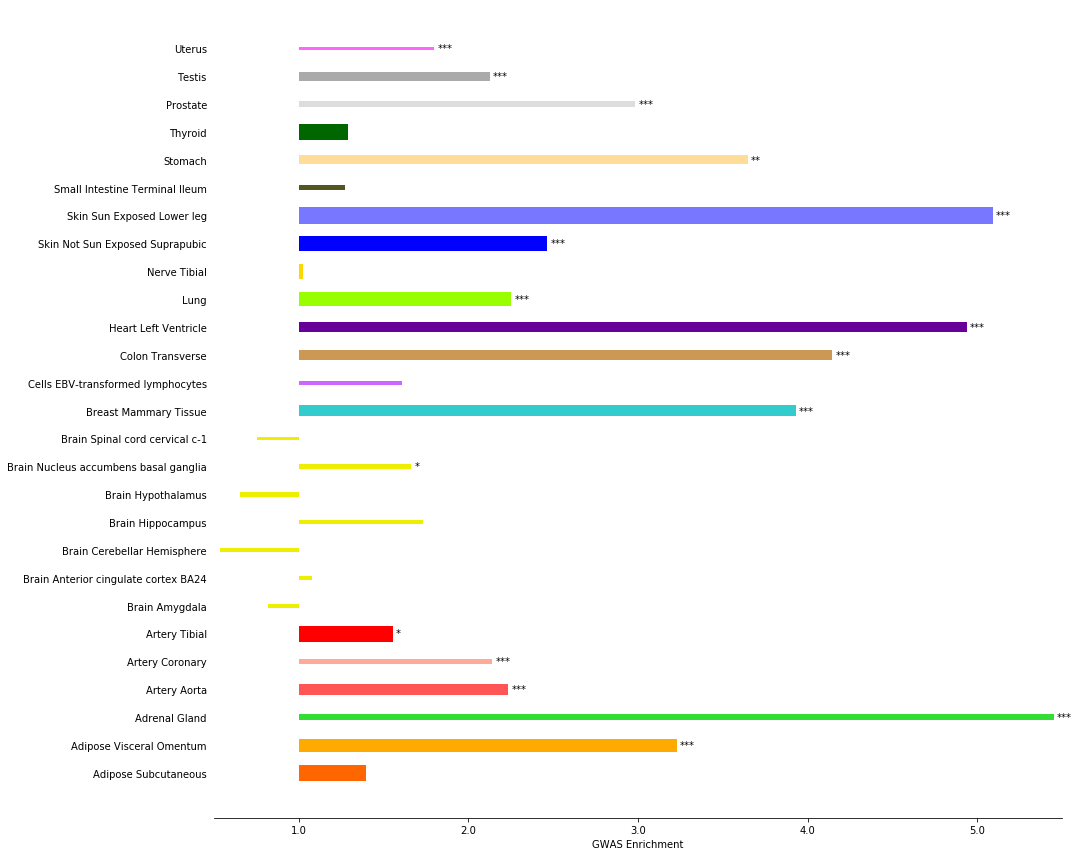

In [111]:
objects = list()
performance = list()
significance = list()
bar_colors = list()
bar_width = list()

for e in GWAS_enrichment_results:
    tshort = e.tissue
    objects.append(tissue_names[tshort])
    performance.append(e.enrichment - 1.0)
    if e.pval <= 0.001:
        significance.append('***')
    elif e.pval <= 0.01:
        significance.append('**')
    elif e.pval <= 0.05:
        significance.append('*')
    else:
        significance.append('')
    bar_colors.append(tissue_colors[tshort])
    bar_width.append(tissue_samples[tshort])

bar_width = np.array(bar_width)

fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(111)

y_pos = np.arange(len(objects))
bar1 = ax1.barh(y_pos, performance, align='center', color = bar_colors, linewidth = 0, height = 0.001 * bar_width)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(objects)
ax1.set_xlabel('GWAS Enrichment')
xmax = np.around(np.max(performance) + 0.05, decimals = 1)
xmin = np.around(np.min(performance) - 0.05, decimals = 1)
ax1.set_xlim([xmin, xmax])

ax1.tick_params(bottom = True, top = False, left = False, right = False, labelleft = True, labelbottom = True)
for side, border in ax1.spines.items():
    if not side == 'bottom':
        border.set_visible(False)
        
# Add p-values beside the bars
for i, rect in enumerate(bar1):
    width = rect.get_width()
    xpos = rect.get_width() + 0.02
    ypos = rect.get_y() + rect.get_height() / 2.0
    ax1.text(xpos, ypos, f'{significance[i]}', ha='left', va='center')

fig.canvas.draw()
xticklabels = [f'{x.get_position()[0] + 1 :3.1f}' for x in ax1.get_xticklabels()]
ax1.set_xticklabels(xticklabels)

outfile = "GWAS_enrichment.png"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')
plt.show()

In [113]:
##### MAF 5% ######

### TODO - change a bit to use my results instead of saikat's

# base = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8"
trans_dict_maf05 = dict()
for tissue in tissuenames:
    tejaas_file = os.path.join(basepath+"_tejaas_permnull_sb0.1_knn", tissue, "trans_eqtls_maf0.05.txt")
    if not os.path.exists(tejaas_file):
        print("{:s} has no trans-eqtl results".format(tissue))
        continue
    #print("Loading ", tissue)
    transeqtls = tejaas_saikat(tejaas_file, dbsnp_dict)
    if len(transeqtls) > 100:
        trans_dict_maf05[tissue] = transeqtls


GWAS_FIELDS = ['tissue', 'inGWAS', 'nTrans', 'enrichment', 'pval']
class GWAS(collections.namedtuple('_GWAS', GWAS_FIELDS)):
    __slots__ = ()

rand_in_gwas_avg, rand_in_gwas_std = sample_background_50000(dbsnp_dict, gwas_rsid_dict)
print(rand_in_gwas_avg, rand_in_gwas_std, rand_in_gwas_avg/50000)

GWAS_BG = rand_in_gwas_avg/50000
print("{: >6}\t{: >6}\t{: >6}\t{: >9}\t{: >9}".format("Tissue","inGWAS","nTrans","enrichment", "pval"))
GWAS_enrichment_results_maf05 = list()
for tissue in tissuenames:
    if tissue in trans_dict_maf05:
        ntrans = len(trans_dict_maf05[tissue])
        
        in_gwas = snp_in_GWAS_catalog(trans_dict_maf05[tissue], gwas_rsid_dict)
        frac_in_gwas = in_gwas / ntrans
        enrichment = frac_in_gwas / GWAS_BG
        
        randfrac_1000_gwas = sample_1000_pval(dbsnp_dict, gwas_rsid_dict, ntrans)
        gpval = GWAS_enrichment_pval(randfrac_1000_gwas, GWAS_BG, enrichment)
        
        GWAS_res = GWAS(tissue=tissue, inGWAS=in_gwas, nTrans=len(trans_dict_maf05[tissue]), enrichment=enrichment, pval=gpval)
        GWAS_enrichment_results_maf05.append(GWAS_res)
        print("{: >6}\t{: >6}\t{: >6}\t{:10g}\t{:10g}".format(tissue, in_gwas, len(trans_dict_maf05[tissue]), enrichment, gpval))

fib has no trans-eqtl results
kc has no trans-eqtl results
bl has no trans-eqtl results
391.8 23.63387399475592 0.007836000000000001
Tissue	inGWAS	nTrans	enrichment	     pval
    as	    10	   613	   2.08183	     0.011
    av	    13	   501	    3.3114	         0
    ag	    12	   265	   5.77884	         0
    aa	    65	  3916	   2.11825	         0
    ac	    57	  3366	   2.16106	         0
    at	     7	   475	   1.88066	     0.033
   bam	    33	  3962	   1.06293	     0.308
   ban	    22	  2154	   1.30341	     0.077
   bhi	     4	   180	   2.83591	     0.013
   bhy	     3	   593	  0.645613	     0.673
   bnu	    11	   819	   1.71401	     0.027
   bsp	     2	   149	   1.71297	     0.095
    br	    22	   764	   3.67481	         0
   ebv	     5	   366	   1.74339	     0.073
  colt	    75	  2310	   4.14338	         0
   hlv	    13	   336	   4.93753	         0
    lu	    18	  1029	   2.23235	         0
    nt	     5	   549	   1.16226	     0.258
  snse	    28	  1449	   2.46601	         0
   sse	 

In [114]:
with open("GWAS_enrichment_results_maf0.05.txt", 'w') as outstream:
    for e in GWAS_enrichment_results_maf05:
        outstream.write("{:s}\t{:d}\t{:d}\t{:g}\t{:g}\n".format(e.tissue, e.inGWAS, e.nTrans, e.enrichment, e.pval))

In [11]:
# read previous file
GWAS_enrich_results_tmp = list()
with open("GWAS_enrichment_results_maf0.05.txt") as instream:
    for line in instream:
        arr = line.rstrip().split()
        tissue = arr[0]
        in_gwas = int(arr[1])
        nTrans = int(arr[2])
        enrichment = float(arr[3])
        pval = float(arr[4])
        GWAS_enrich_results_tmp.append(GWAS(tissue=tissue, inGWAS=in_gwas, nTrans=nTrans, enrichment=enrichment, pval=pval))
    
objects = list()
performance = list()
significance = list()
bar_colors = list()
bar_width = list()

for e in GWAS_enrich_results_tmp:
    tshort = e.tissue
    objects.append(tissue_names[tshort])
    performance.append(e.enrichment - 1.0)
    if e.pval <= 0.001:
        significance.append('***')
    elif e.pval <= 0.01:
        significance.append('**')
    elif e.pval <= 0.05:
        significance.append('*')
    else:
        significance.append('')
    bar_colors.append(tissue_colors[tshort])
    bar_width.append(tissue_samples[tshort])

bar_width = np.array(bar_width)

fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(111)

y_pos = np.arange(len(objects))
bar1 = ax1.barh(y_pos, performance, align='center', color = bar_colors, linewidth = 0, height = 0.001 * bar_width)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(objects)
ax1.set_xlabel('GWAS Enrichment')
xmax = np.around(np.max(performance) + 0.05, decimals = 1)
xmin = np.around(np.min(performance) - 0.05, decimals = 1)
ax1.set_xlim([xmin, xmax])

ax1.tick_params(bottom = True, top = False, left = False, right = False, labelleft = True, labelbottom = True)
for side, border in ax1.spines.items():
    if not side == 'bottom':
        border.set_visible(False)
        
# Add p-values beside the bars
for i, rect in enumerate(bar1):
    width = rect.get_width()
    xpos = rect.get_width() + 0.02
    ypos = rect.get_y() + rect.get_height() / 2.0
    ax1.text(xpos, ypos, f'{significance[i]}', ha='left', va='center')

fig.canvas.draw()
xticklabels = [f'{x.get_position()[0] + 1 :3.1f}' for x in ax1.get_xticklabels()]
ax1.set_xticklabels(xticklabels)

outfile = "GWAS_enrichment_maf05.png"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')
plt.show()

NameError: name 'tissue_names' is not defined

In [116]:
##### MAF 5% + LD ######

basepath = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8"
trans_dict_maf05_ldpruned = dict()
for tissue in tissuenames:
    tejaas_file = os.path.join(basepath+"_tejaas_permnull_sb0.1_knn", tissue, "trans_eqtls_maf0.05.txt.ld_prune")
    if not os.path.exists(tejaas_file):
        print("{:s} has no trans-eqtl results".format(tissue))
        continue
    #print("Loading ", tissue)
    transeqtls = tejaas_saikat(tejaas_file, dbsnp_dict)
    if len(transeqtls) > 100:
        trans_dict_maf05_ldpruned[tissue] = transeqtls


GWAS_FIELDS = ['tissue', 'inGWAS', 'nTrans', 'enrichment', 'pval']
class GWAS(collections.namedtuple('_GWAS', GWAS_FIELDS)):
    __slots__ = ()

rand_in_gwas_avg, rand_in_gwas_std = sample_background_50000(dbsnp_dict, gwas_rsid_dict)
print(rand_in_gwas_avg, rand_in_gwas_std, rand_in_gwas_avg/50000)

GWAS_BG = rand_in_gwas_avg/50000
print("{: >6}\t{: >6}\t{: >6}\t{: >9}\t{: >9}".format("Tissue","inGWAS","nTrans","enrichment", "pval"))
GWAS_enrichment_results_maf05_ldpruned = list()
for tissue in tissuenames:
    if tissue in trans_dict_maf05_ldpruned:
        ntrans = len(trans_dict_maf05_ldpruned[tissue])
        
        in_gwas = snp_in_GWAS_catalog(trans_dict_maf05_ldpruned[tissue], gwas_rsid_dict)
        frac_in_gwas = in_gwas / ntrans
        enrichment = frac_in_gwas / GWAS_BG
        
        randfrac_1000_gwas = sample_1000_pval(dbsnp_dict, gwas_rsid_dict, ntrans)
        gpval = GWAS_enrichment_pval(randfrac_1000_gwas, GWAS_BG, enrichment)
        
        GWAS_res = GWAS(tissue=tissue, inGWAS=in_gwas, nTrans=len(trans_dict_maf05_ldpruned[tissue]), enrichment=enrichment, pval=gpval)
        GWAS_enrichment_results_maf05_ldpruned.append(GWAS_res)
        print("{: >6}\t{: >6}\t{: >6}\t{:10g}\t{:10g}".format(tissue, in_gwas, len(trans_dict_maf05_ldpruned[tissue]), enrichment, gpval))
        
with open("GWAS_enrichment_results_maf0.05_ldpruned.txt", 'w') as outstream:
    for e in GWAS_enrichment_results_maf05_ldpruned:
        outstream.write("{:s}\t{:d}\t{:d}\t{:g}\t{:g}\n".format(e.tissue, e.inGWAS, e.nTrans, e.enrichment, e.pval))    

fib has no trans-eqtl results
kc has no trans-eqtl results
bl has no trans-eqtl results
391.8 23.63387399475592 0.007836000000000001
Tissue	inGWAS	nTrans	enrichment	     pval
    as	     6	   219	   3.49633	     0.001
    av	     3	   204	   1.87671	     0.078
    aa	    27	  1293	   2.66484	         0
    ac	    29	  1101	   3.36137	         0
    at	     5	   146	   4.37042	         0
   bam	    20	  1312	   1.94537	         0
   ban	    13	   737	   2.25103	     0.002
   bhy	     2	   214	   1.19267	     0.214
   bnu	     6	   316	   2.42309	     0.012
    br	    11	   299	   4.69491	         0
   ebv	     4	   146	   3.49633	     0.007
  colt	    27	   839	   4.10684	         0
   hlv	     7	   143	   6.24694	         0
    lu	     7	   365	   2.44743	     0.012
    nt	     3	   206	   1.85849	     0.077
  snse	     8	   527	   1.93725	     0.022
   sse	     3	   141	   2.71524	     0.024
   sto	     3	   133	   2.87856	     0.015
   thy	     5	   309	   2.06499	     0.027
   pro	 

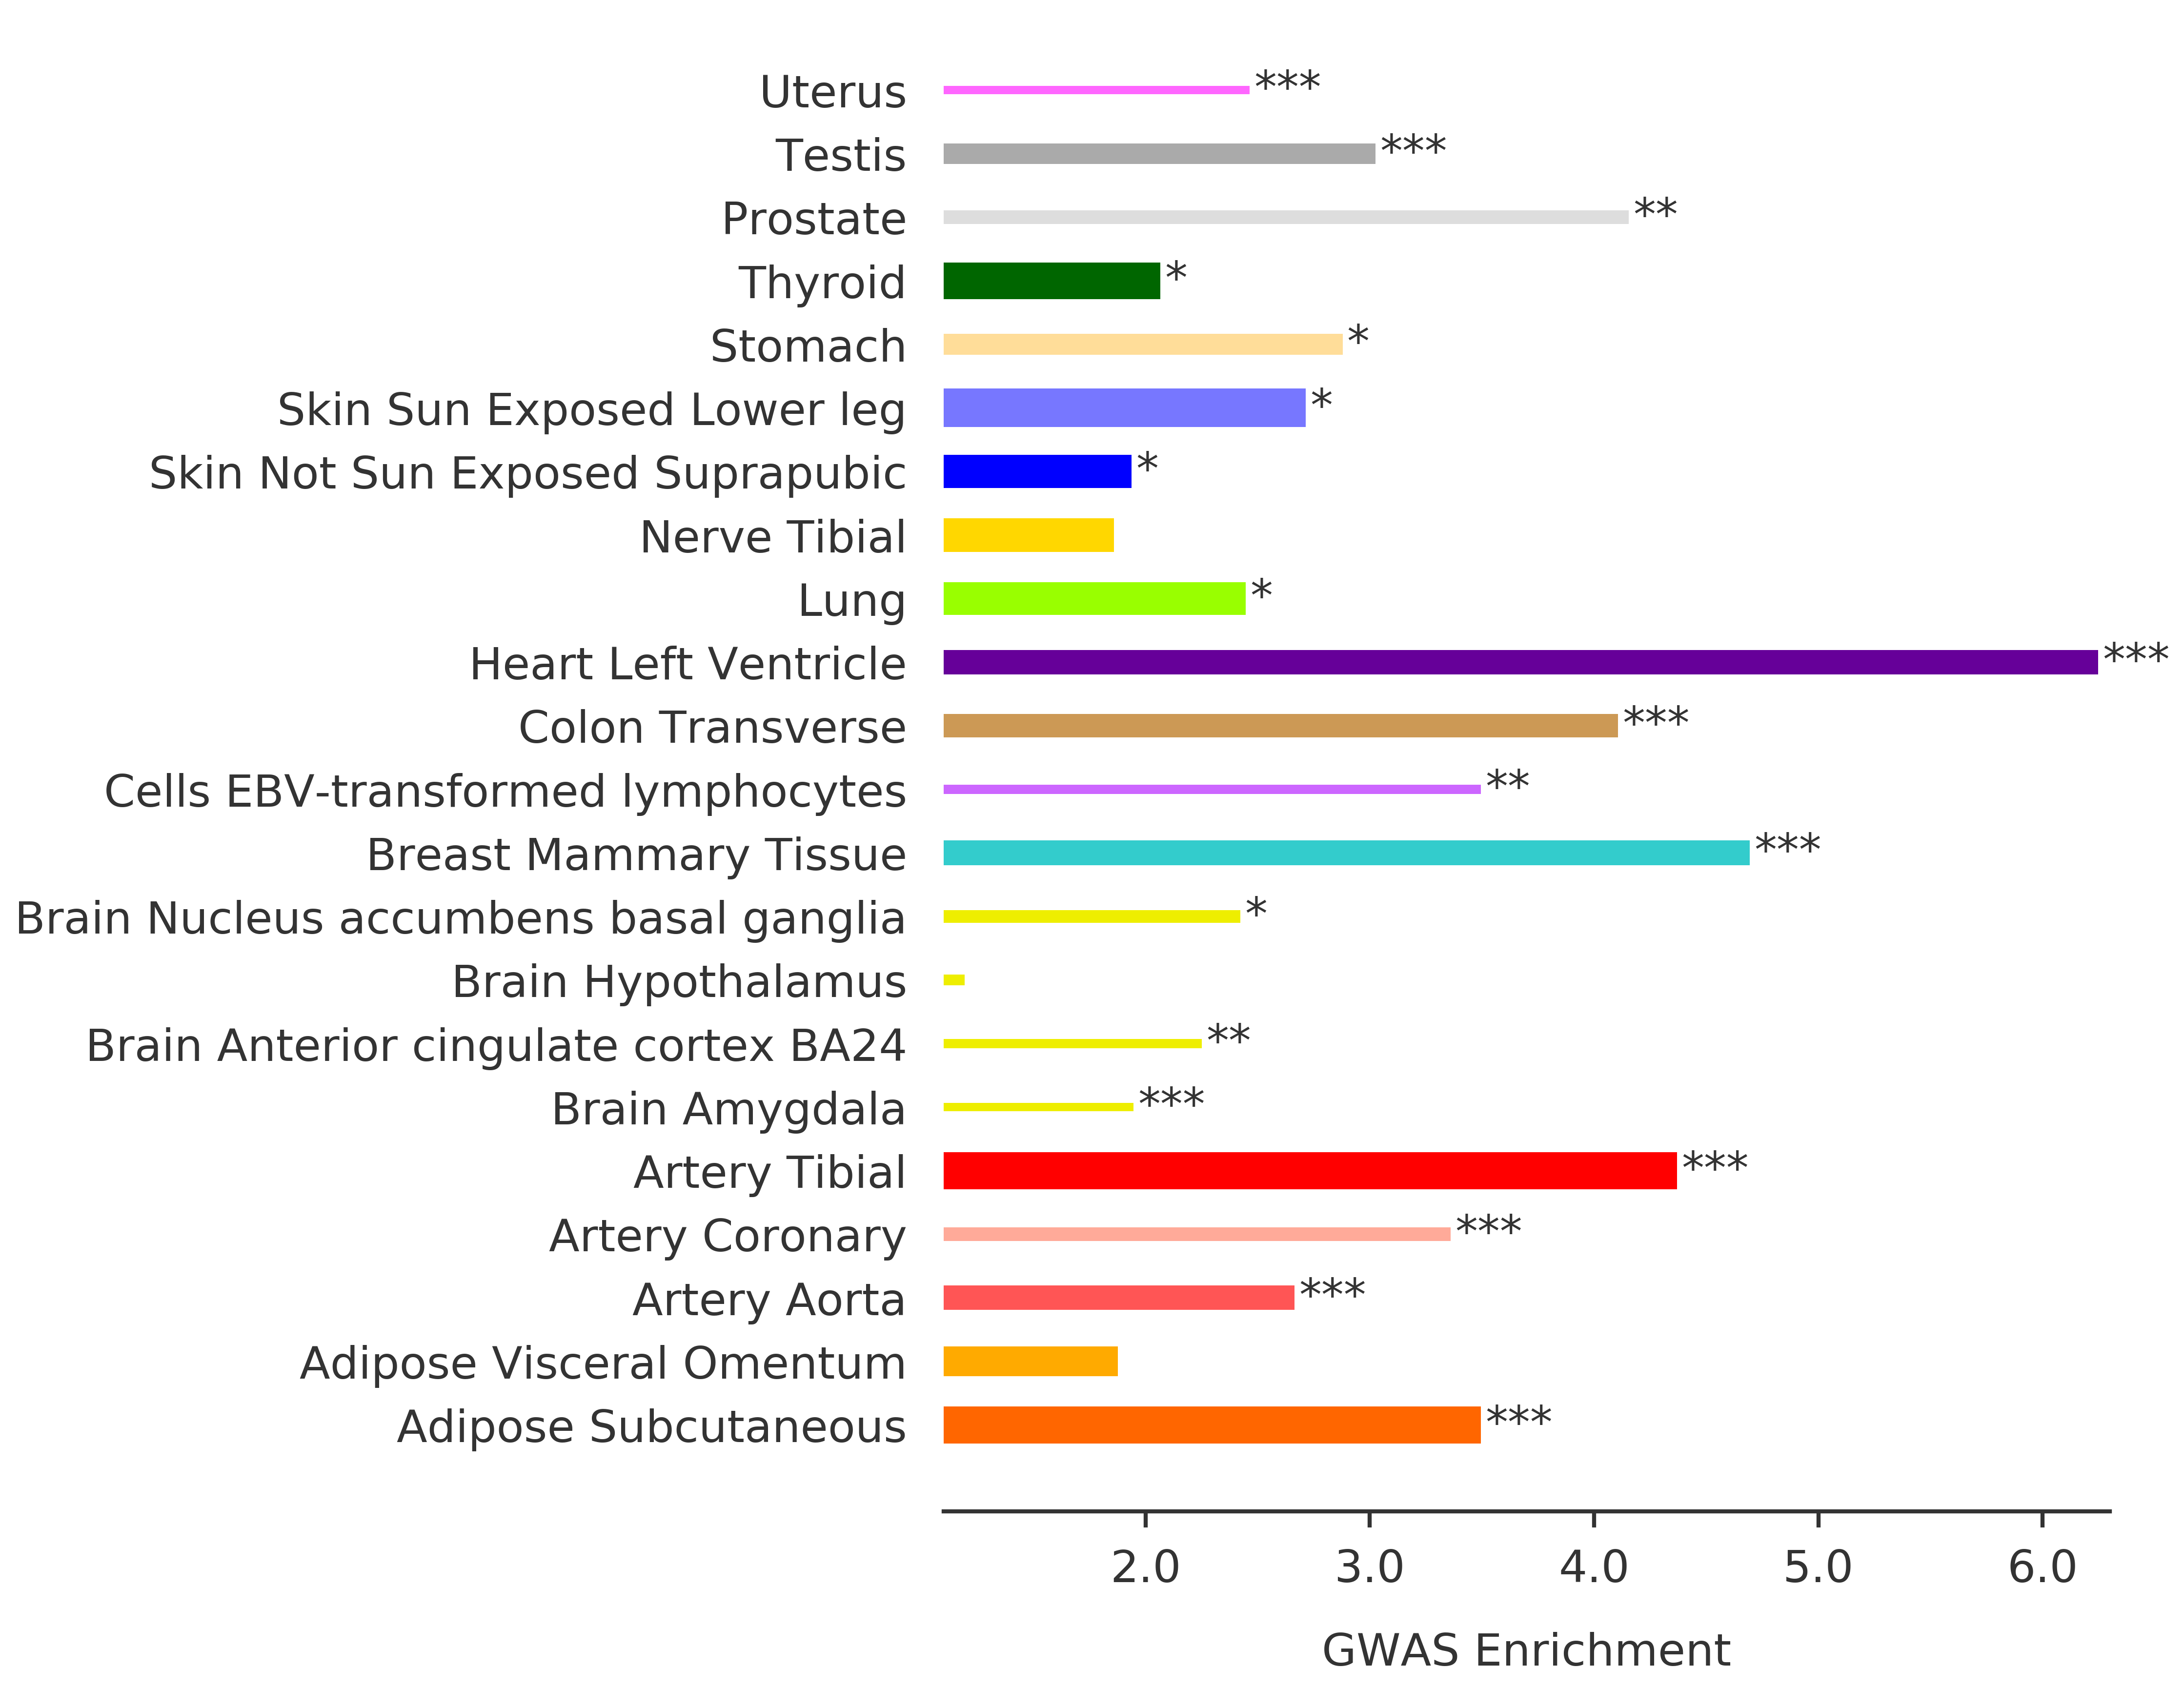

In [16]:
# read previous file
GWAS_enrich_results_tmp = list()
with open("GWAS_enrichment_results_maf0.05_ldpruned.txt") as instream:
    for line in instream:
        arr = line.rstrip().split()
        tissue = arr[0]
        in_gwas = int(arr[1])
        nTrans = int(arr[2])
        enrichment = float(arr[3])
        pval = float(arr[4])
        GWAS_enrich_results_tmp.append(GWAS(tissue=tissue, inGWAS=in_gwas, nTrans=nTrans, enrichment=enrichment, pval=pval))
    

objects = list()
performance = list()
significance = list()
bar_colors = list()
bar_width = list()

for e in GWAS_enrich_results_tmp:
    tshort = e.tissue
    objects.append(tissue_names[tshort])
    performance.append(e.enrichment - 1.0)
    if e.pval <= 0.001:
        significance.append('***')
    elif e.pval <= 0.01:
        significance.append('**')
    elif e.pval <= 0.05:
        significance.append('*')
    else:
        significance.append('')
    bar_colors.append(tissue_colors[tshort])
    bar_width.append(tissue_samples[tshort])

bar_width = np.array(bar_width)

fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(111)

y_pos = np.arange(len(objects))
bar1 = ax1.barh(y_pos, performance, align='center', color = bar_colors, linewidth = 0, height = 0.001 * bar_width)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(objects)
ax1.set_xlabel('GWAS Enrichment')
xmax = np.around(np.max(performance) + 0.05, decimals = 1)
xmin = np.around(np.min(performance) - 0.05, decimals = 1)
ax1.set_xlim([xmin, xmax])

ax1.tick_params(bottom = True, top = False, left = False, right = False, labelleft = True, labelbottom = True)
for side, border in ax1.spines.items():
    if not side == 'bottom':
        border.set_visible(False)
        
# Add p-values beside the bars
for i, rect in enumerate(bar1):
    width = rect.get_width()
    xpos = rect.get_width() + 0.02
    ypos = rect.get_y() + rect.get_height() / 2.0
    ax1.text(xpos, ypos, f'{significance[i]}', ha='left', va='center')

fig.canvas.draw()
xticklabels = [f'{x.get_position()[0] + 1 :3.1f}' for x in ax1.get_xticklabels()]
ax1.set_xticklabels(xticklabels)

outfile = "GWAS_enrichment_maf05_ldpruned.png"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')
plt.show()

In [17]:
GWAS_enrich_results_tmp

[GWAS(tissue='as', inGWAS=6, nTrans=219, enrichment=3.49633, pval=0.001),
 GWAS(tissue='av', inGWAS=3, nTrans=204, enrichment=1.87671, pval=0.078),
 GWAS(tissue='aa', inGWAS=27, nTrans=1293, enrichment=2.66484, pval=0.0),
 GWAS(tissue='ac', inGWAS=29, nTrans=1101, enrichment=3.36137, pval=0.0),
 GWAS(tissue='at', inGWAS=5, nTrans=146, enrichment=4.37042, pval=0.0),
 GWAS(tissue='bam', inGWAS=20, nTrans=1312, enrichment=1.94537, pval=0.0),
 GWAS(tissue='ban', inGWAS=13, nTrans=737, enrichment=2.25103, pval=0.002),
 GWAS(tissue='bhy', inGWAS=2, nTrans=214, enrichment=1.19267, pval=0.214),
 GWAS(tissue='bnu', inGWAS=6, nTrans=316, enrichment=2.42309, pval=0.012),
 GWAS(tissue='br', inGWAS=11, nTrans=299, enrichment=4.69491, pval=0.0),
 GWAS(tissue='ebv', inGWAS=4, nTrans=146, enrichment=3.49633, pval=0.007),
 GWAS(tissue='colt', inGWAS=27, nTrans=839, enrichment=4.10684, pval=0.0),
 GWAS(tissue='hlv', inGWAS=7, nTrans=143, enrichment=6.24694, pval=0.0),
 GWAS(tissue='lu', inGWAS=7, nTrans